In [61]:
import cv2
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import pickle

In [62]:
images = pd.read_csv("image_info.csv")

In [63]:
def get_vector(image_path, bins=32):
    # check whether the file exists
    if not os.path.isfile(image_path):
        raise ValueError(f"Die Datei {image_path} existiert nicht.")
    
    # load image
    image = cv2.imread(image_path)
    
    # checker whether the image has been loaded successfully
    if image is None:
        raise ValueError(f"Das Bild {image_path} konnte nicht geladen werden.")

    # extract rgb information of the image
    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    
    vector = np.concatenate([red, green, blue], axis=0).reshape(-1)
    return vector

In [64]:
# store all color vector
color_vectors = {}

# iterate through all images
for index, row in tqdm(images.iterrows()):
    image_path = os.path.join(row['root'], row['file'])
    try:
        # calculate color embedding
        vector = get_vector(image_path)
        color_vectors[row['image_id']] = vector
    except ValueError as e:
        print(e)
        color_vectors[row['image_id']] = None  # Handle images that couldn't be loaded

0it [00:00, ?it/s]

Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0298.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0267.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0273.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0071.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0688.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0677.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0111.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images

libpng error: IDAT: CRC error


Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0294.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0257.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0727.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0690.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0684.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0135.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images/DIV2K_train_HR 2/0653.png konnte nicht geladen werden.
Das Bild /Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/test_images

In [65]:
# remove vectors with None values
valid_color_vectors = {key: value for key, value in color_vectors.items() if value is not None}

In [66]:
# store the color vectors in a pickle file
with open('color_vectors.pkl', 'wb') as f:
    pickle.dump(valid_color_vectors, f)

In [67]:
color_embeddings = pd.read_pickle("color_vectors.pkl")

In [68]:
image_ids, vectors = zip(*color_embeddings.items())
embeddings = np.array(vectors)

In [69]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial import distance

In [70]:
# path of input image
input_image_path = '/Users/nick/Downloads/person-near-alternative-energy-plant.jpg'

# calculate color embedding for the input image
query_vector = get_vector(input_image_path)

In [71]:
# calculate similarity scores
scores = cosine_similarity([query_vector], embeddings)[0]

In [72]:
# Find the closest 10 vectors and their similarity scores
closest_indices = np.argsort(-scores)[:10]
closest_vectors = scores[closest_indices]

print("Indices of the 10 closest vectors:\n", closest_indices)
print("Similarity/Distance of the 10 closest vectors:\n", scores[closest_indices])

Indices of the 10 closest vectors:
 [ 33 286 252 134 103 398 267 414 291 309]
Similarity/Distance of the 10 closest vectors:
 [0.91905737 0.89893305 0.8902274  0.8865578  0.8653331  0.8548381
 0.8523877  0.84555024 0.8450433  0.84165335]


In [73]:
# find image IDs of the 10 most similar images
closest_image_ids = [image_ids[i] for i in closest_indices]
print("IDs der 10 ähnlichsten Bilder:\n", closest_image_ids)

IDs der 10 ähnlichsten Bilder:
 [34, 287, 253, 135, 104, 631, 268, 688, 292, 310]


In [74]:
import matplotlib.pyplot as plt

# function to display an image
def show_image(image_path, title):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

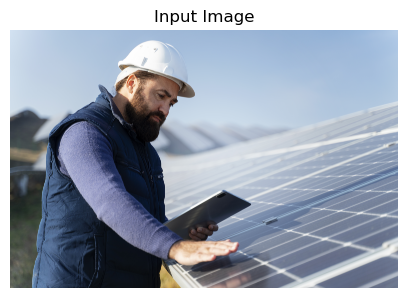

In [75]:
# display input image
show_image(input_image_path, "Input Image")

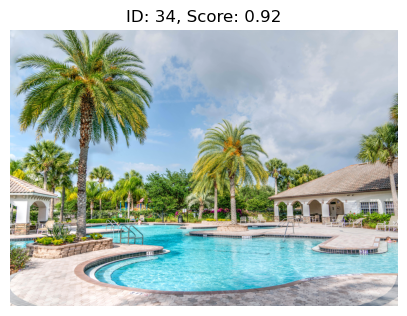

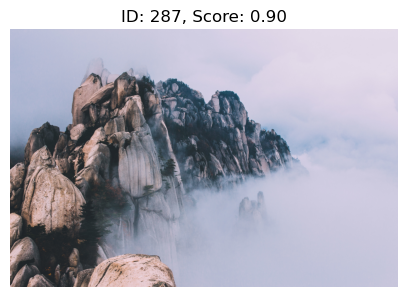

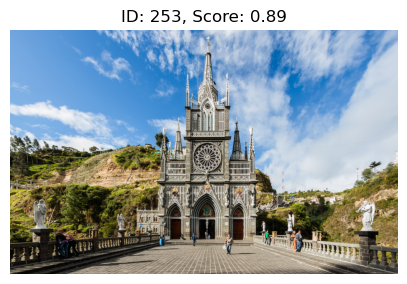

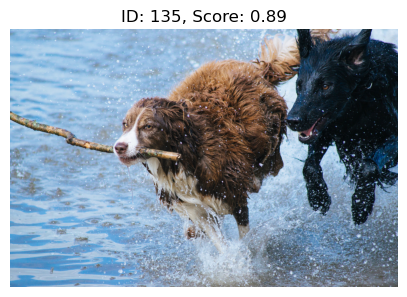

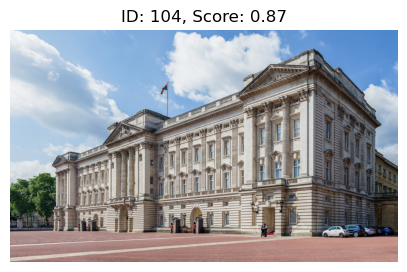

In [78]:
# Retrieve information of the most similar image from the CSV file
for i in range(5):
    closest_image_id = closest_image_ids[i]
    closest_score = closest_vectors[i]
    closest_image_info = images[images['image_id'] == closest_image_id].iloc[0]

    # get image path and set title
    image_path = os.path.join(closest_image_info['root'], closest_image_info['file'])
    title = f"ID: {closest_image_id}, Score: {closest_score:.2f}"

    # display most similar image
    show_image(image_path, title)